In [2]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np


## Cancer Detection using CNN's

I will use a CNN model to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates). The data has 440,050 images in the training set and 114,916 images in validation (test) set. 

In [3]:
df_data = pd.read_csv('data/histopathologic-cancer-detection/train_labels.csv')


print(len(os.listdir('data/histopathologic-cancer-detection/train')))
print(len(os.listdir('data/histopathologic-cancer-detection/test')))

440050
114916


In [5]:
# source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    
    df[col_name]=  df[col_name].astype(float)
    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['id'] + '.tif'
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()

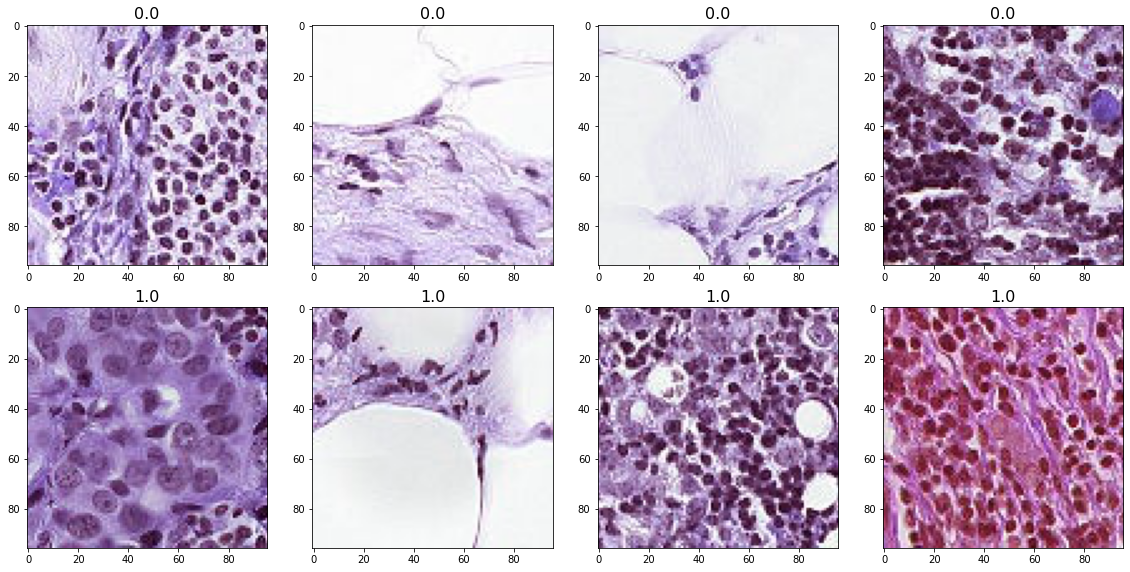

In [6]:
draw_category_images('label',4, df_data,'data/histopathologic-cancer-detection/train/')

In [8]:
from sklearn.model_selection import train_test_split

y = df_data['label']
df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)

print(df_train)
print(df_val)
print(y)

                                              id  label
134709  2ddb582347063e13f6e8e8bcc693c2ddc65f5781    0.0
122063  9563cbc9f43d2d2ecc1e8b757ee85637db430fe7    0.0
171972  2ca2f3a7c24ba5c5638089e1c08088ac246454fe    1.0
63378   ab452f00d0fc2a3dd7c4781c0dcaaecf4d71e4ab    1.0
36782   85aaec3a61c47e33d4bad167f9c1a013a2ff2401    0.0
...                                          ...    ...
117398  9e04c5701b81604b04bd340fb86f26c0ec0fa84d    0.0
87646   86611a3dae286bf57808cce6bd952777a83e2f98    0.0
99059   7344089a9732d851d3a5d41cf9c7849e53fc1e94    0.0
121588  a49c538708c85c9be22946c40e284d357bf960b5    0.0
21829   d7a3e35ffb2dfa20db4aff2c9e91edb64f4a369c    0.0

[198022 rows x 2 columns]
                                              id  label
79961   0d8c9abf388785a016d72e609ab932b7e134f827    0.0
45724   5566aa9c1d698535c449144d72e98556bf77fd47    0.0
81384   358c0ab1962f8f1c202b146d88b35f55252bde9f    1.0
91989   00f81cefedcc1fb79a5c500677aad14438c50296    0.0
177529  e7a806a270062

In [9]:
import os
import shutil

base_dir = 'data/histopathologic-cancer-detection/split'
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

no_tumor_tissue = os.path.join(train_dir, 'tumor_0')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(train_dir, 'tumor_1')
os.mkdir(has_tumor_tissue)


# create new folders inside val_dir
no_tumor_tissue = os.path.join(val_dir, 'tumor_0')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(val_dir, 'tumor_1')
os.mkdir(has_tumor_tissue)

df_data_ind = df_data.set_index('id')

train_list = list(df_train['id'])
val_list = list(df_val['id'])

for image in train_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data_ind.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'tumor_0'
    if target == 1:
        label = 'tumor_1'
    
    # source path to image
    src = os.path.join('data/histopathologic-cancer-detection/train', fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data_ind.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'tumor_0'
    if target == 1:
        label = 'tumor_1'
    

    # source path to image
    src = os.path.join('data/histopathologic-cancer-detection/train', fname)
    # destination path to image
    dst = os.path.join(val_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

FileExistsError: [Errno 17] File exists: 'data/histopathologic-cancer-detection/split'

In [10]:
from keras.preprocessing.image import ImageDataGenerator

train_path = 'data/histopathologic-cancer-detection/split/train_dir'
valid_path = 'data/histopathologic-cancer-detection/split/val_dir'
test_path ='data/histopathologic-cancer-detection/test'

img_size = 96
num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 32
val_batch_size = 32


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

datagen = ImageDataGenerator(rescale=1.0/255)

datagen = ImageDataGenerator(preprocessing_function=lambda x:(x - x.mean()) / x.std() if x.std() > 0 else x,
                            horizontal_flip=True,
                            vertical_flip=True)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(img_size,img_size),
                                        batch_size=train_batch_size,
                                        class_mode='binary')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(img_size,img_size),
                                        batch_size=val_batch_size,
                                        class_mode='binary')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(img_size,img_size),
                                        batch_size=1,
                                        class_mode='binary',
                                        shuffle=False)

2024-03-05 17:19:40.993015: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-05 17:19:41.231187: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 17:19:41.231239: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 17:19:41.273806: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-05 17:19:41.369375: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-05 17:19:41.371094: I tensorflow/core/platform/cpu_feature_guard.cc:1

Found 198022 images belonging to 2 classes.
Found 22003 images belonging to 2 classes.
Found 22003 images belonging to 2 classes.


In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D,MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [12]:
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)
                              
                              
callbacks_list = [reducel, earlystopper]

In [14]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.5

In [12]:

model1 = Sequential()
model1.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model1.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model1.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model1.add(MaxPooling2D(pool_size = pool_size)) 
model1.add(Dropout(dropout_conv))

model1.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model1.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model1.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model1.add(MaxPooling2D(pool_size = pool_size))
model1.add(Dropout(dropout_conv))

model1.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model1.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model1.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model1.add(MaxPooling2D(pool_size = pool_size))
model1.add(Dropout(dropout_conv))

model1.add(Flatten())
model1.add(Dense(256, activation = "relu"))
model1.add(Dropout(dropout_dense))
model1.add(Dense(1, activation = "softmax"))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 45, 45, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 45, 45, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 43, 43, 64)        18496     
                                                        

In [13]:
model1.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

filepath1 = "model.h5"

history1 = model1.fit(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=10, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/10


2024-03-04 20:17:19.618124: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 36192256 exceeds 10% of free system memory.
2024-03-04 20:17:19.668302: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 34668544 exceeds 10% of free system memory.
2024-03-04 20:17:19.682754: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33177600 exceeds 10% of free system memory.
2024-03-04 20:17:19.777650: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 17132544 exceeds 10% of free system memory.
2024-03-04 20:17:19.780560: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 17132544 exceeds 10% of free system memory.


5813/6189 [===========================>..] - ETA: 5:37 - loss: 0.4211 - accuracy: 0.4047

<Figure size 432x288 with 0 Axes>

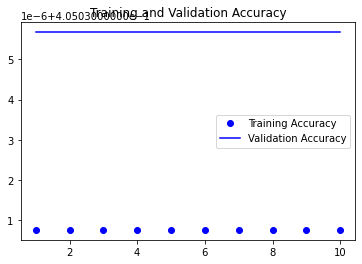

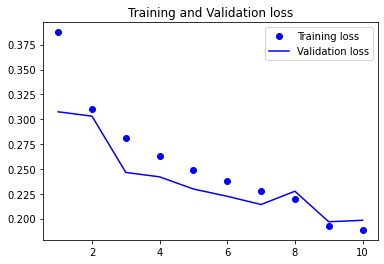

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.figure()

In [15]:

model2 = Sequential()
model2.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (img_size, img_size, 3)))
model2.add(Conv2D(first_filters, kernel_size, use_bias=False))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPool2D(pool_size = pool_size)) 
model2.add(Dropout(dropout_conv))

model2.add(Conv2D(second_filters, kernel_size, use_bias=False))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(Conv2D(second_filters, kernel_size, use_bias=False))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPool2D(pool_size = pool_size))
model2.add(Dropout(dropout_conv))

model2.add(Conv2D(third_filters, kernel_size, use_bias=False))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(Conv2D(third_filters, kernel_size, use_bias=False))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPool2D(pool_size = pool_size))
model2.add(Dropout(dropout_conv))

#model2.add(GlobalAveragePooling2D())
model2.add(Flatten())
model2.add(Dense(256, use_bias=False))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(Dropout(dropout_dense))
model2.add(Dense(1, activation = "sigmoid"))


model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9216      
                                                                 
 batch_normalization (Batch  (None, 92, 92, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 92, 92, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 46, 46, 32)       

In [16]:

model2.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])
           
history2 = model2.fit(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=20, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/20
6189/6189 [==============================] - 4079s 659ms/step - loss: 0.4407 - accuracy: 0.8014 - val_loss: 0.5607 - val_accuracy: 0.7490 - lr: 1.0000e-04
Epoch 2/20
6189/6189 [==============================] - ETA: 0s - loss: 0.3412 - accuracy: 0.8534
Epoch 2: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
6189/6189 [==============================] - 4478s 724ms/step - loss: 0.3412 - accuracy: 0.8534 - val_loss: 0.7023 - val_accuracy: 0.7097 - lr: 1.0000e-04
Epoch 3/20
6189/6189 [==============================] - ETA: 0s - loss: 0.3021 - accuracy: 0.8737
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
Restoring model weights from the end of the best epoch: 1.
6189/6189 [==============================] - 4820s 779ms/step - loss: 0.3021 - accuracy: 0.8737 - val_loss: 1.6820 - val_accuracy: 0.5961 - lr: 1.0000e-05
Epoch 3: early stopping


<Figure size 432x288 with 0 Axes>

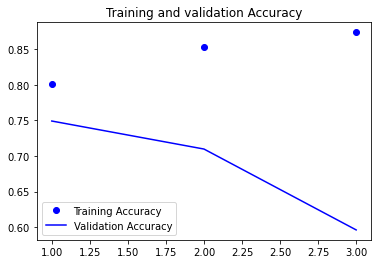

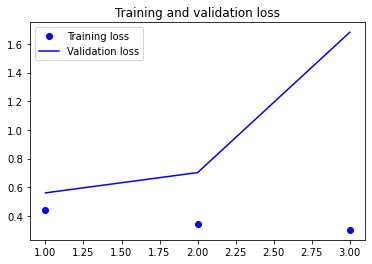

<Figure size 432x288 with 0 Axes>

In [18]:

acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs2 = range(1, len(acc2) + 1)

plt.plot(epochs2, acc2, 'bo', label='Training Accuracy')
plt.plot(epochs2, val_acc2, 'b', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.legend()
plt.figure()


plt.plot(epochs2, loss2, 'bo', label='Training loss')
plt.plot(epochs2, val_loss2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

In [21]:
num_test_images = 57458
predictions = model2.predict(test_gen, steps=num_test_images, verbose=1)

/tmp/ipykernel_983/1820181717.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model2.predict_generator(test_gen, steps=num_test_images, verbose=1)


57458/57458 [==============================] - 202s 4ms/step


In [22]:
df_preds = pd.DataFrame(predictions, columns=['no_tumor_tissue', 'has_tumor_tissue'])

df_preds.head()

test_filenames = test_gen.filenames

# add the filenames to the dataframe
df_preds['file_names'] = test_filenames

df_preds.head()

def extract_id(x):
    
    # split into a list
    a = x.split('/')
    # split into a list
    b = a[1].split('.')
    extracted_id = b[0]
    
    return extracted_id

df_preds['id'] = df_preds['file_names'].apply(extract_id)

df_preds.head()


y_pred = df_preds['has_tumor_tissue']

# get the id column
image_id = df_preds['id']

submission = pd.DataFrame({'id':image_id, 
                           'label':y_pred, 
                          }).set_index('id')

submission.to_csv('preds.csv', columns=['label']) 

submission.head()

ValueError: Shape of passed values is (22003, 1), indices imply (22003, 2)